In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ortools.linear_solver import pywraplp
import random
pd.options.display.max_rows = 5000
pd.options.display.max_columns = 500

In [28]:
###
## Load dataframe where each row is a single applicant
###

df = pd.read_csv('./df_test.csv')
df['ml_outcomes'] = df['ml_outcomes_div']#.round(2)# + df['R']*0.13


In [29]:
df['T'] = df['T'].clip(lower=40,upper=100)

In [30]:
df['ml_outcomes'].describe()

count    1000000.000000
mean           0.524683
std            0.197853
min            0.028493
25%            0.385027
50%            0.505615
75%            0.661109
max            1.241547
Name: ml_outcomes, dtype: float64

In [31]:
df['T']

0         67
1         46
2         79
3         45
4         63
          ..
999995    48
999996    40
999997    51
999998    43
999999    44
Name: T, Length: 1000000, dtype: int64

In [32]:
FRAC_ADMIT = df[['A']].sum()/len(df)


In [33]:
FRAC_ADMIT

A    0.485046
dtype: float64

In [34]:
len(df)

1000000

<AxesSubplot:>

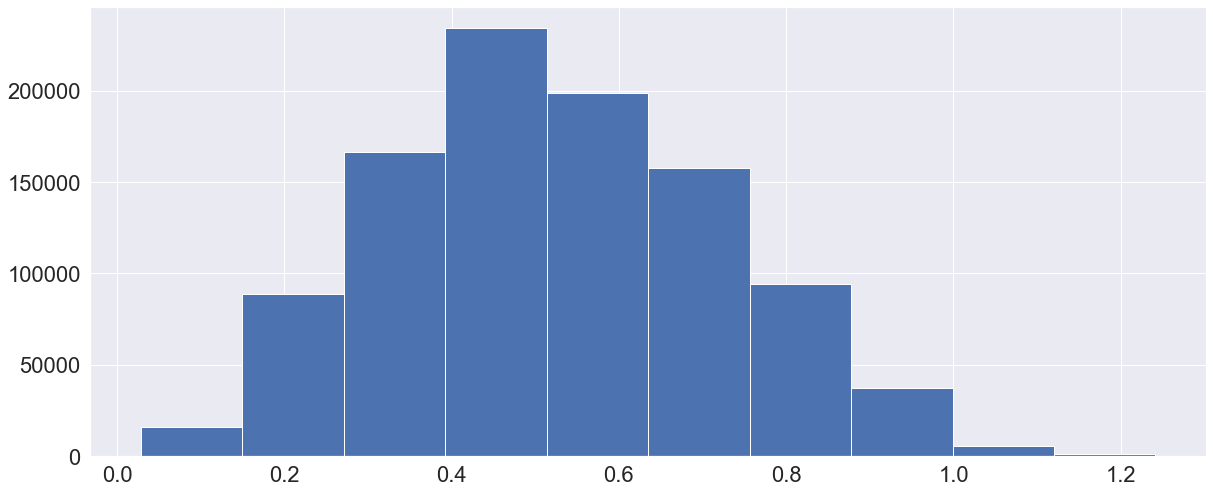

In [35]:
df['ml_outcomes'].hist()

In [36]:
##
# R = race, T = test score, ml_outcomes = expected utility from admitting, 
# ml_outcomes_{} counterfactual utility given race 
##

df[['R','T','ml_outcomes','T_black','T_white','ml_outcomes_black','ml_outcomes_white','ml_outcomes_decision','B_p']].sort_values(by='ml_outcomes')



,R,T,ml_outcomes,T_black,T_white,ml_outcomes_black,ml_outcomes_white,ml_outcomes_decision,B_p
601095,0,40,0.028493,11,10,-3.670390,-3.529184,0,0
724501,0,40,0.028493,8,10,-3.906891,-3.529184,0,0
87558,0,40,0.028493,9,10,-3.828057,-3.529184,0,0
275905,0,40,0.030758,8,11,-3.906891,-3.450350,0,0
937351,0,40,0.033198,11,12,-3.670390,-3.371517,0,0
...,...,...,...,...,...,...,...,...,...
897432,1,100,1.228517,106,121,3.818789,5.221331,1,1
992959,1,100,1.230113,107,124,3.897623,5.457832,1,1
934719,1,100,1.230113,107,124,3.897623,5.457832,1,1
792897,1,100,1.231593,108,125,3.976456,5.536665,1,1


In [37]:
###
## Get total utility from admitting people in a stratum 
###

df_ = df[['R','T','ml_outcomes']].groupby(['R','T']).sum().reset_index()

In [38]:
###
## Get number of people in each stratum
###

df_count = df[['R','T','ml_outcomes']].groupby(['R','T']).count().reset_index()
df_count.columns = ['R','T','Count']
df_count['N'] = df_count['Count']

In [39]:
###
## Get boards passage probability in each stratum
###

df_prob = df[['R','T','B_p']].groupby(['R','T']).mean().reset_index()
df_prob.columns = ['R','T','ml_outcomes_prob']

#df_prob = df[['R','T','ml_outcomes_prob']]

In [40]:
###
## Merge summary tables to get one table with Race, Test Score, SUM(Utility), COUNT(applicants), E(Y(1)|X )
###

dff = df_.merge(df_count[['N']],left_index=True,right_index=True)
dff = dff.merge(df_prob[['ml_outcomes_prob']],left_index=True,right_index=True).sort_values(by='ml_outcomes',ascending=False).reset_index().sort_values(by='index').reset_index()



In [41]:
# final info table
dff.sort_values(by='T')

,level_0,index,R,T,ml_outcomes,N,ml_outcomes_prob
0,1,0,0,40,14318.441230,77772,0.189696
61,0,61,1,40,37015.195426,93391,0.143761
1,61,1,0,41,3332.184891,13197,0.254906
62,46,62,1,41,5387.249714,11629,0.209046
2,57,2,0,42,3783.147256,14134,0.271402
63,42,63,1,42,5704.736971,11965,0.223652
3,53,3,0,43,4356.076772,15371,0.274933
64,40,64,1,43,6047.470069,12319,0.239630
4,49,4,0,44,4935.947948,16471,0.296218
65,35,65,1,44,6371.760697,12602,0.249087


In [42]:
dff['Pr(X=X_j)'] = dff['N']/(dff['N']).sum()

In [43]:
dff[dff['R']==1].sort_values(by='T')

,level_0,index,R,T,ml_outcomes,N,ml_outcomes_prob,Pr(X=X_j)
61,0,61,1,40,37015.195426,93391,0.143761,0.093391
62,46,62,1,41,5387.249714,11629,0.209046,0.011629
63,42,63,1,42,5704.736971,11965,0.223652,0.011965
64,40,64,1,43,6047.470069,12319,0.239630,0.012319
65,35,65,1,44,6371.760697,12602,0.249087,0.012602
66,33,66,1,45,6459.181932,12400,0.270081,0.012400
67,30,67,1,46,6649.801974,12389,0.286545,0.012389
68,28,68,1,47,6837.375098,12361,0.297144,0.012361
69,26,69,1,48,6847.985115,12013,0.313161,0.012013
70,25,70,1,49,6888.334565,11726,0.332168,0.011726


0.27649999999999997 309851.7856704964
0.277 309902.0922029913
0.27749999999999997 309938.1052079342
0.27799999999999997 309974.84238791186
0.27849999999999997 310010.4680354351
0.27899999999999997 310044.2850277067
0.27949999999999997 310080.079558723
0.27999999999999997 310118.17434336885
0.28049999999999997 310140.6473280095
0.28099999999999997 310148.36708346853
0.2815 310155.8510087353
0.282 310161.9938675497
0.2825 310166.2430429345
0.283 310170.7734354978
0.2835 310176.45932138537
0.284 310183.17415389983
0.2845 310191.2861368312
0.285 310201.4097019627
0.2855 310213.36980520986
0.286 310227.3857357395
0.2865 310242.5834495424
0.287 310258.9404291963
0.2875 310277.39312588447
0.288 310298.0203042441
0.2885 310320.74084095226
0.289 310345.55627335777
0.2895 310371.7989374778
0.29 310400.2511989322
0.2905 310429.3923153599
0.291 310456.3147480106
0.2915 310443.07996114827
0.292 310431.46287721145
0.2925 310421.4805804615
0.293 310413.1503965739
0.2935 310406.4006406499
0.294 310400

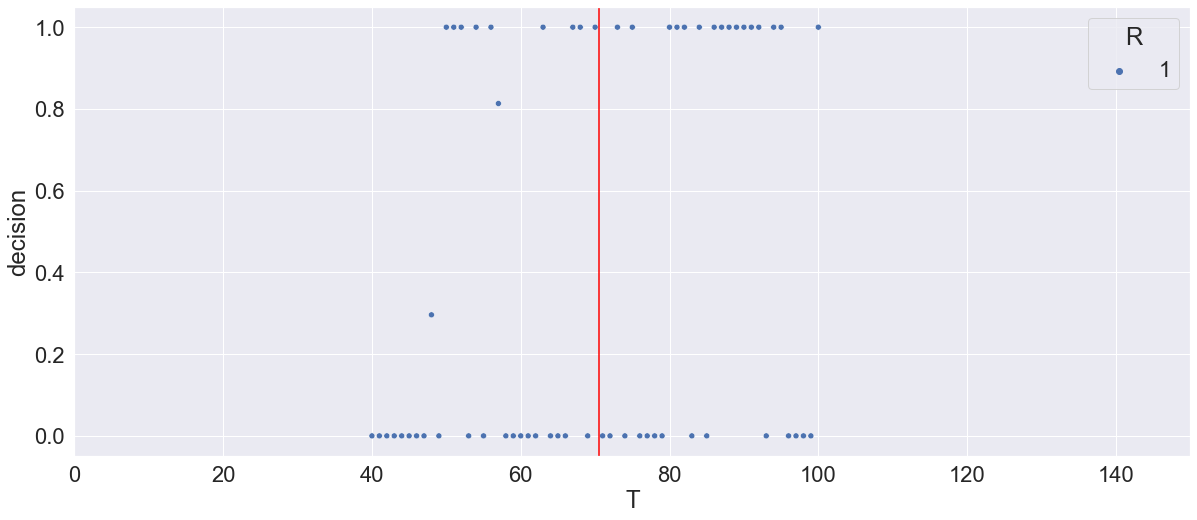

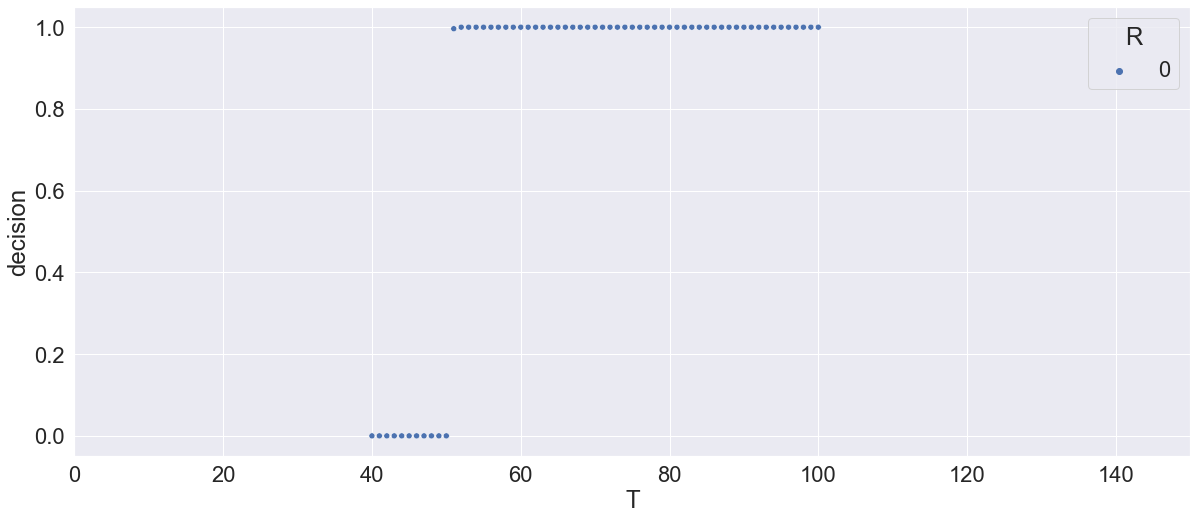

-----------
0.3 310453.19721736165
0.3005 310468.8902605814
0.301 310486.54707670305
0.3015 310505.70558318315
0.302 310525.57772414916
0.3025 310532.5448714662
0.303 310528.840656622
0.3035 310526.9076381363
0.304 310526.7650171731
0.3045 310528.4322734447
0.305 310531.9291702794
0.3055 310537.27575980354
0.306 310544.4923882359
0.3065 310553.06229304743
0.307 310560.5210665504
0.3075 310569.5696569934
0.308 310580.57438198355
0.3085 310593.55716041604
0.309 310608.54023988615
0.3095 310625.5462028776
0.31 310644.597973085
0.3105 310665.71882188454
0.311 310688.93237494974
0.3115 310714.26261901925
0.312 310741.73390882224
0.3125 310770.4905642484
0.313 310765.08483400574
0.3135 310757.709995325
0.314 310751.97301055933
0.3145 310747.8901912315
0.315 310745.4780661832
0.3155 310744.75338520453
0.316 310745.7331227418
0.3165 310748.43448167254
0.317 310752.8748971645
0.3175 310759.0720406077
0.318 310766.18333913333
0.3185 310774.90704564226
0.319 310785.4431805248
0.3195 310797.810413

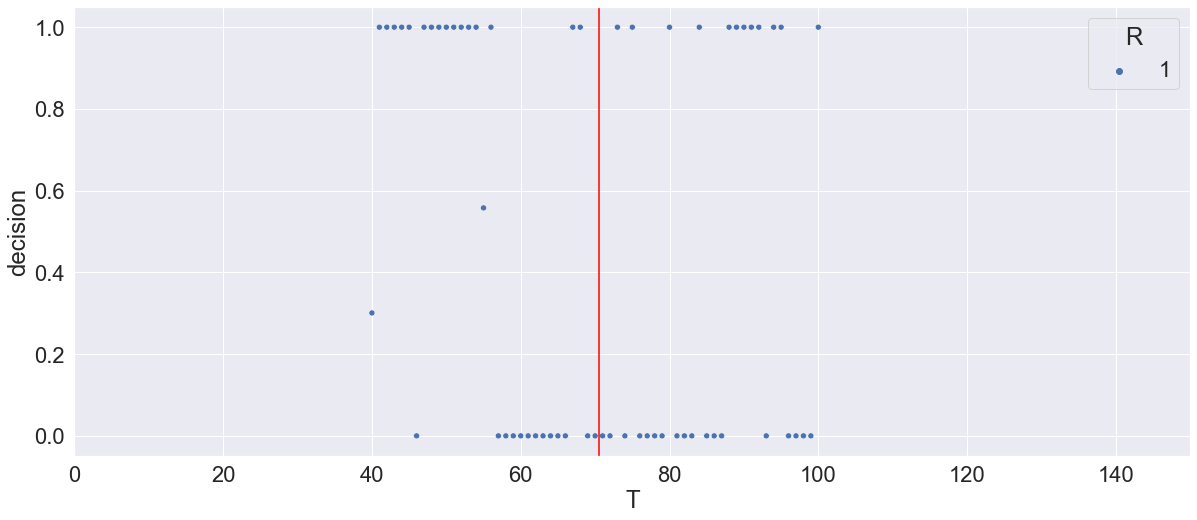

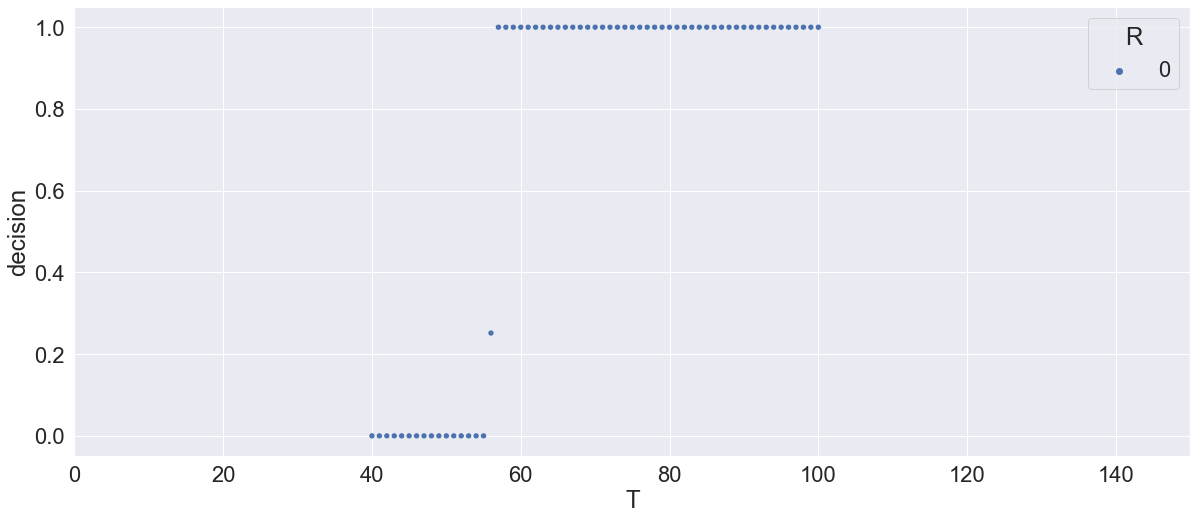

-----------
0.35000000000000003 311470.0202761048
0.35050000000000003 311490.2694017858
0.35100000000000003 311512.1824003837
0.35150000000000003 311535.7744711755
0.35200000000000004 311561.0609991266
0.35250000000000004 311572.57645121304
0.35300000000000004 311568.20752449724
0.35350000000000004 311565.1428388252
0.35400000000000004 311563.3367179887
0.35450000000000004 311562.87018837087
0.35500000000000004 311563.75396655366
0.35550000000000004 311565.9988837343
0.35600000000000004 311569.61588726036
0.35650000000000004 311574.616042191
0.35700000000000004 311581.0105328834
0.35750000000000004 311588.81066460547
0.35800000000000004 311598.02786517376
0.35850000000000004 311608.67368661787
0.35900000000000004 311620.7598068741
0.35950000000000004 311634.29803150415
0.36000000000000004 311649.3002954441
0.36050000000000004 311665.77866478096
0.36100000000000004 311683.47372089396
0.36150000000000004 311702.6032400464
0.36200000000000004 311715.07895311323
0.36250000000000004 311711.

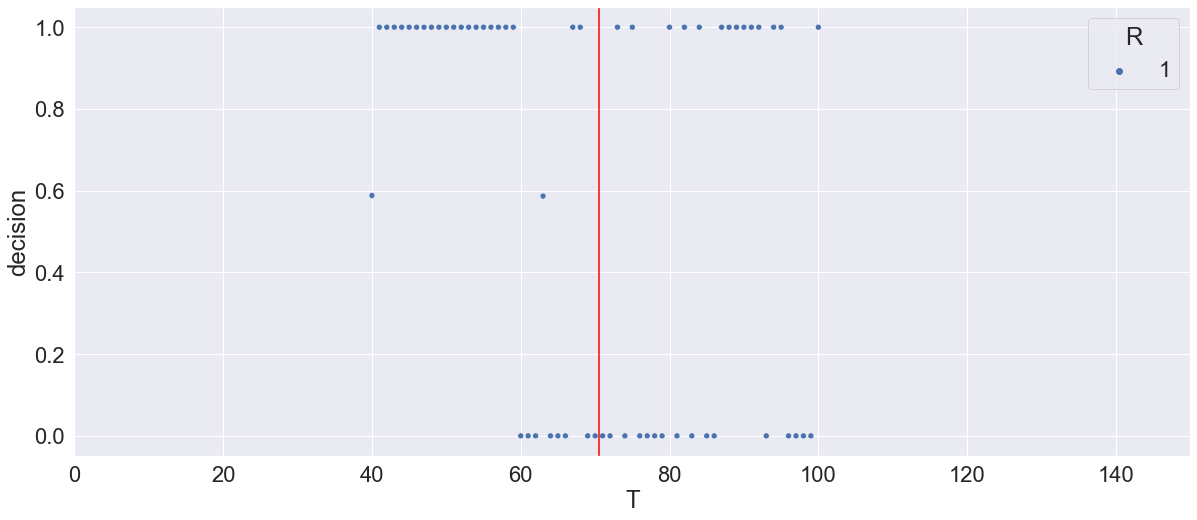

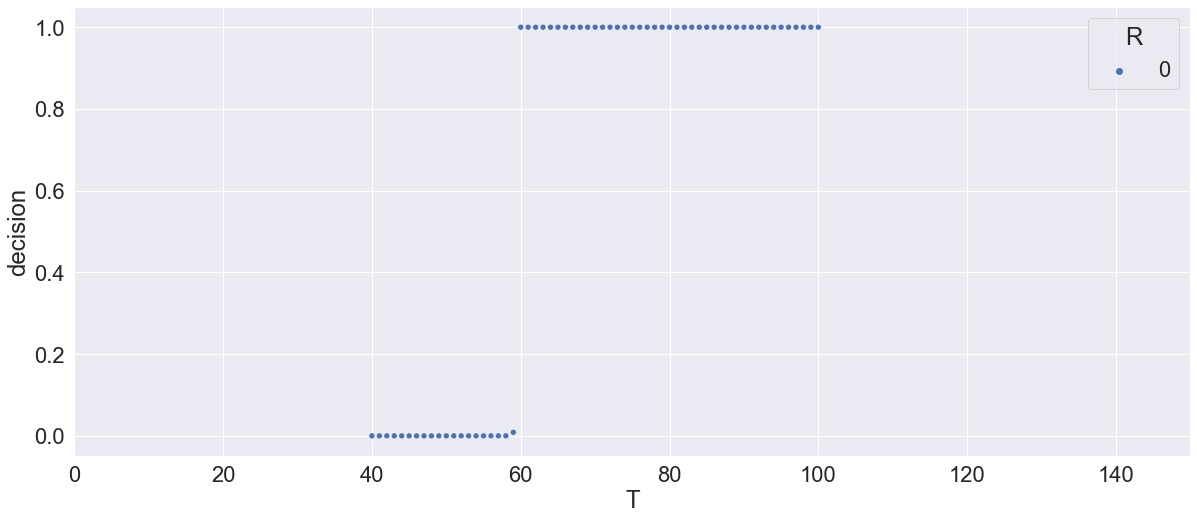

-----------
0.4 311743.27175827377
0.4005 311732.8040050098
0.401 311723.3259727364
0.4015 311714.8438866205
0.402 311707.23854698986
0.4025 311700.1181253475
0.403 311693.58009046945
0.4035 311688.02658649813
0.404 311683.4553119873
0.4045 311679.90861416585
0.405 311677.39303342515
0.4055 311668.35286249814
0.406 311648.8842106725
0.40650000000000003 311630.328131569
0.40700000000000003 311612.6901683177
0.40750000000000003 311595.9759090333
0.40800000000000003 311580.1909872722
0.40850000000000003 311565.3410824947
0.40900000000000003 311551.40707211365
0.40950000000000003 311536.7844816139
0.41000000000000003 311522.83821252466
0.41050000000000003 311509.83461364266
0.41100000000000003 311497.77950519015
0.41150000000000003 311486.6787554023
0.41200000000000003 311476.48952868086
0.41250000000000003 311466.7656728292
0.41300000000000003 311454.9956015017
0.41350000000000003 311430.5784067245
0.41400000000000003 311406.1009720529
0.41450000000000004 311377.45539917616
0.415000000000

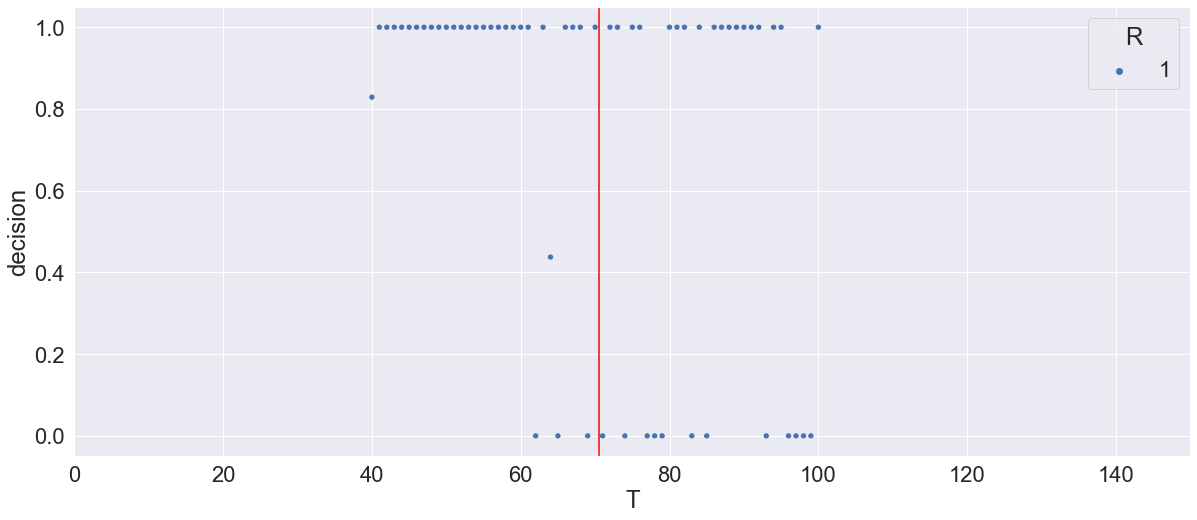

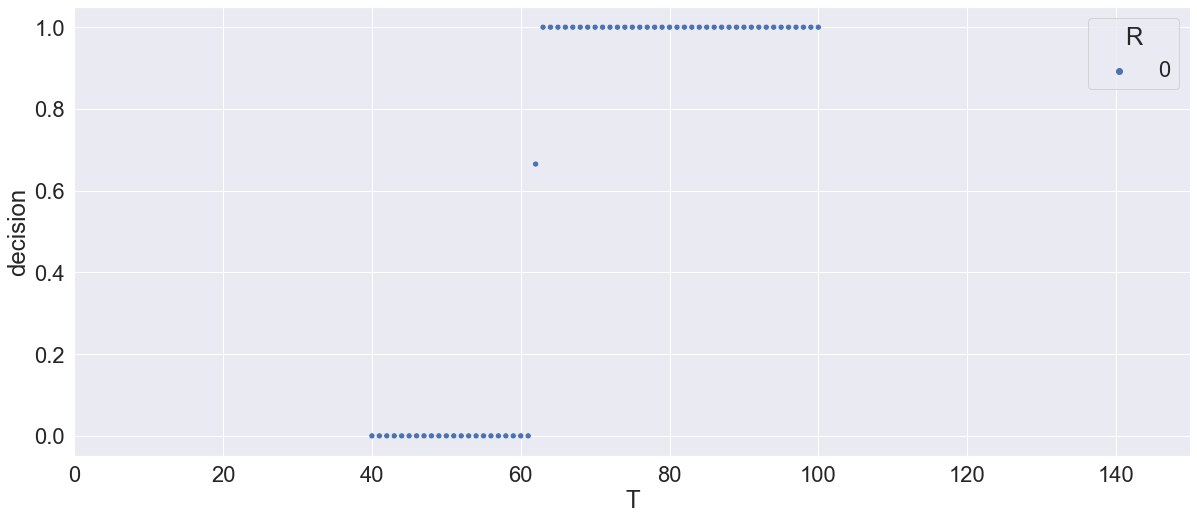

-----------
0.45 293831.582728697
0.4505 293578.10502161697
0.451 293324.62699265545
0.4515 293071.1489636939
0.452 292817.6709347322
0.4525 292564.1907041536
0.453 292310.70947791525
0.4535 292057.2282516767
0.454 291803.7470254381
0.4545 291550.2657991997
0.455 291296.78457296116
0.4555 291043.30334672256
0.456 290789.82212048414
0.4565 290536.3408942458
0.457 290282.85966800724
0.4575 290029.3751223289
0.458 289775.8471037789
0.4585 289522.31908522855
0.459 289268.7910666785
0.4595 289015.2630481282
0.46 288761.73502957815
0.4605 288508.2070110277
0.461 288254.67899247765
0.4615 288001.15097392746
0.462 287747.62295537733
0.4625 287494.08840673097
0.463 287240.43358844524
0.4635 286986.77877015935
0.464 286733.02340584307
0.4645 286479.02870045387
0.465 286225.0339950647
0.4655 285971.0392896756
0.466 285717.0445842864
0.4665 285462.54397473566
0.467 285207.36580770573
0.4675 284952.00243936706
0.468 284695.5861466982
0.4685 284438.7211793065
0.46900000000000003 284181.8562119147
0.

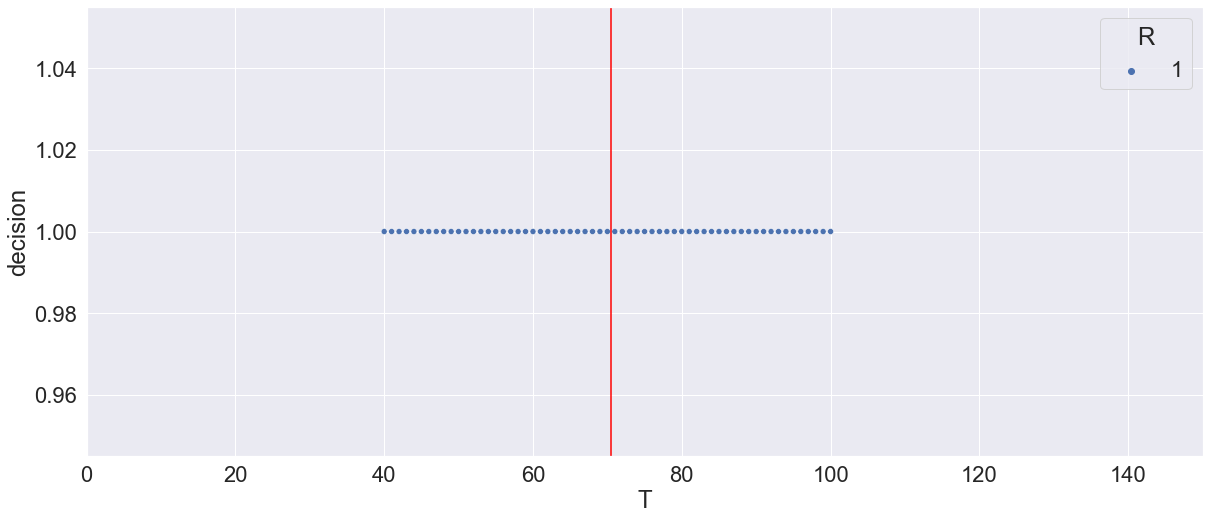

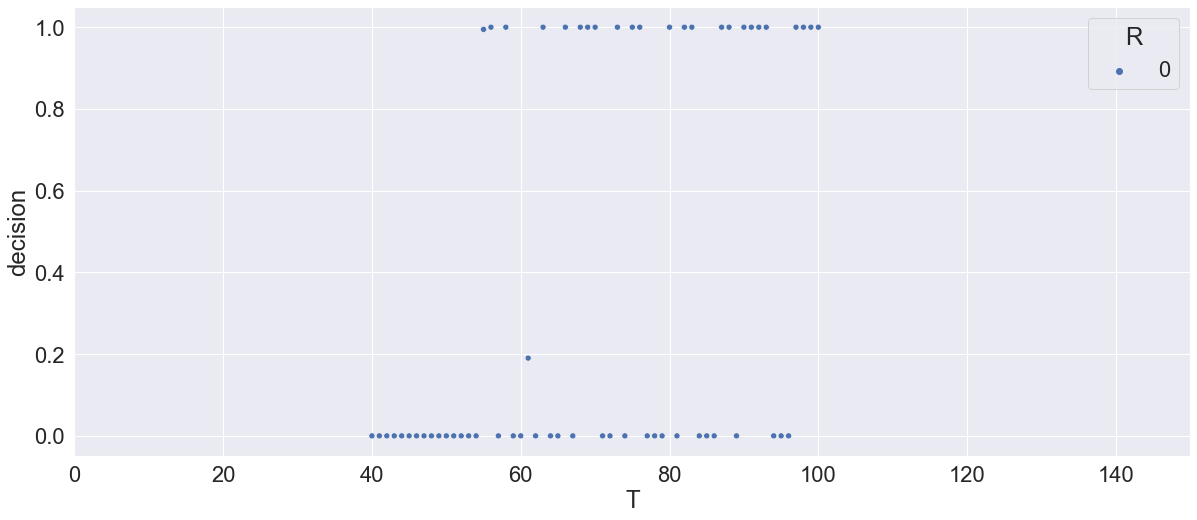

-----------
0.5 268221.34742643335
0.5005 267962.6246106798
0.501 267703.9017949259
0.5015000000000001 267445.17897917225
0.502 267185.9774754557
0.5025 266925.88031624496
0.503 266665.3060361535
0.5035000000000001 266404.72425773006
0.504 266143.61924465967
0.5045 265882.5142315895
0.505 265621.4092185191
0.5055000000000001 265360.3042054488
0.506 265099.1991923784
0.5065 264838.09417930804
0.507 264576.98049878574
0.5075000000000001 264315.47925340553
0.508 264053.76791522274
0.5085 263792.0565770397
0.509 263530.3452388569
0.5095000000000001 263268.63390067406
0.51 263006.9225624913
0.5105 262745.2112243083
0.511 262483.4998861255
0.5115000000000001 262221.78854794253
0.512 261960.07720975974
0.5125 261698.3658715768
0.513 261436.65453339394
0.5135000000000001 261174.943195211
0.514 260913.23185702832
0.5145 260651.52051884547
0.515 260389.8091806624
0.5155000000000001 260127.33132097483
0.516 259864.83734285223
0.5165 259602.31734177665
0.517 259339.7272090562
0.5175000000000001 25

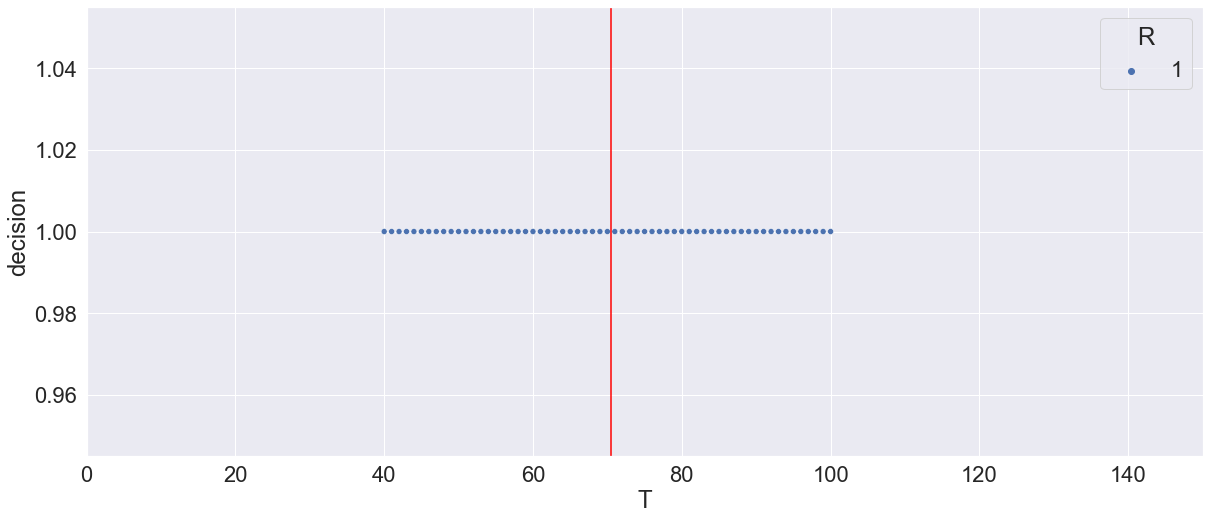

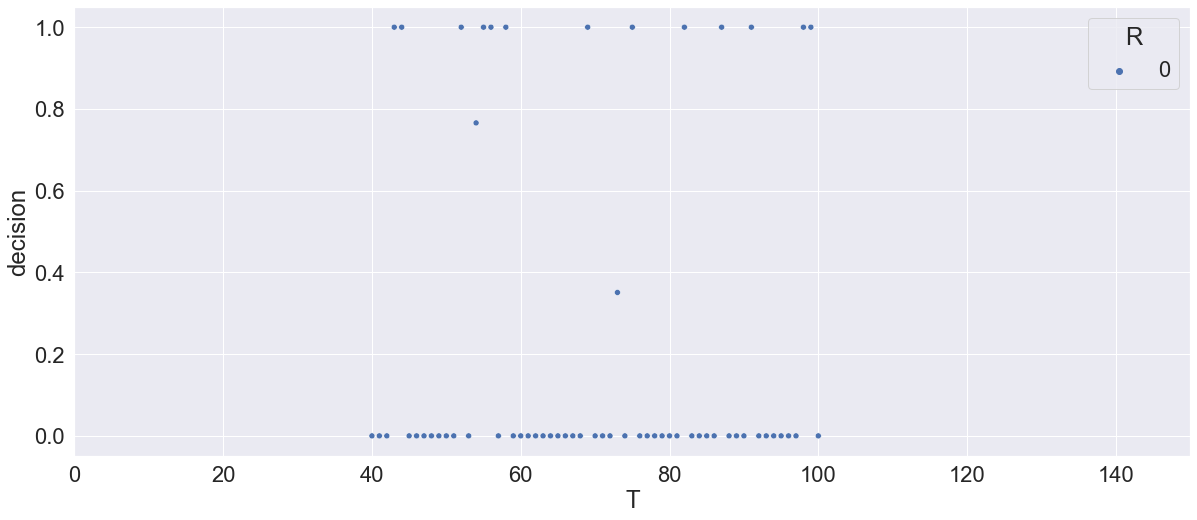

-----------
0.5499999999999999 241816.2752741736
0.5505 241549.95854789572
0.5509999999999999 241283.641821618
0.5514999999999999 241017.32509534023
0.5519999999999999 240751.00836906242
0.5525 240484.69164278454
0.5529999999999999 240218.3749165067
0.5534999999999999 239952.05819022897
0.5539999999999999 239685.74146395116
0.5545 239419.42473767334
0.5549999999999999 239153.10801139547
0.5554999999999999 238886.79128511786
0.5559999999999999 238620.4441144426
0.5565 238353.9058616794
0.5569999999999999 238087.367608916
0.5574999999999999 237820.8293561529
0.5579999999999999 237554.29110338967
0.5585 237287.75285062628
0.5589999999999999 237021.21459786317
0.5594999999999999 236754.67634509987
0.5599999999999999 236488.13809233665
0.5605 236221.59983957346
0.5609999999999999 235955.06158681022
0.5614999999999999 235688.5233340469
0.5619999999999999 235421.98508128352
0.5625 235155.44682852042
0.563 234888.90857575712
0.5634999999999999 234622.37032299393
0.564 234355.83207023042
0.5645

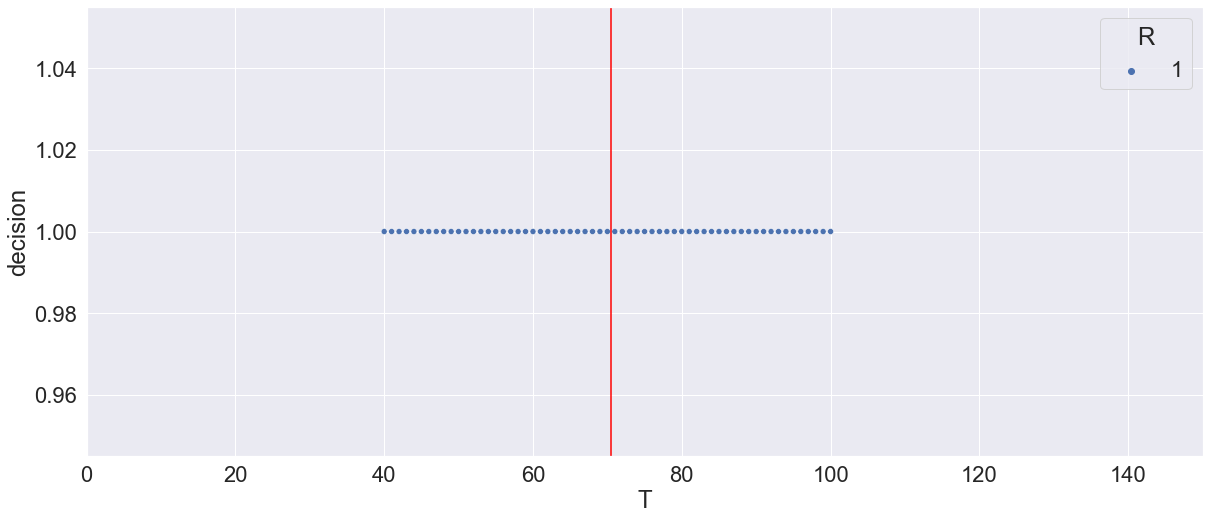

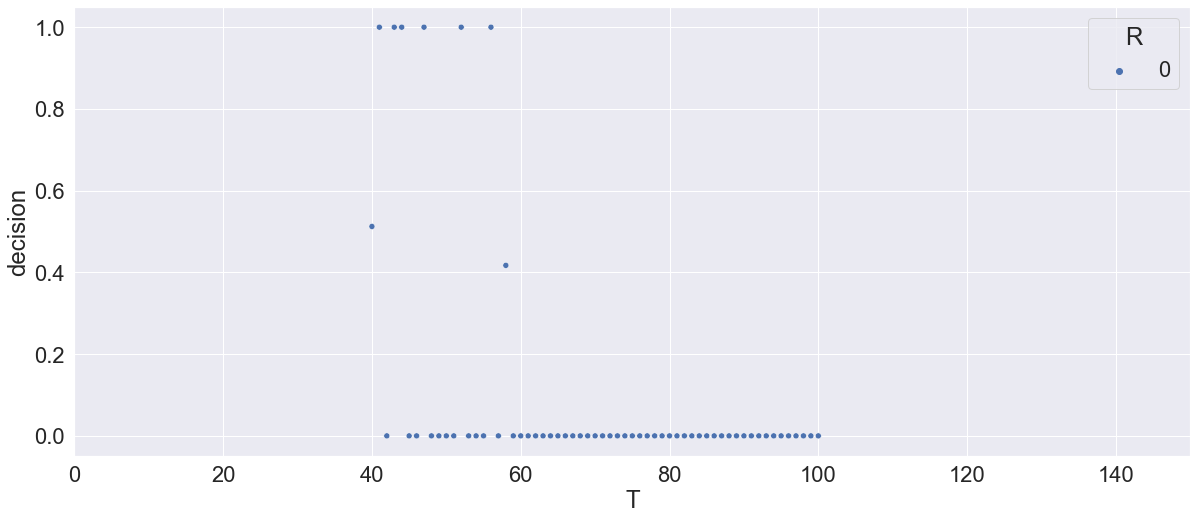

-----------
0.6 205388.1310796052
0.6005 204876.92272561626
0.601 204366.28358733316
0.6014999999999999 203856.04567226575
0.602 203346.93159188743
0.6025 202838.93401385538
0.603 202332.04566947478
0.6034999999999999 201825.17150231692
0.604 201318.39667372947
0.6045 200812.29521503733
0.605 200307.2785976482
0.6054999999999999 199803.33983479658
0.606 199299.93049288265
0.6065 198795.28414426825
0.607 198290.4157525568
0.6074999999999999 197768.2535613992
0.608 197234.47714407352
0.6085 196696.84380582586
0.609 196159.89772444018
0.6094999999999999 195622.58120332647
0.61 195086.50763384657


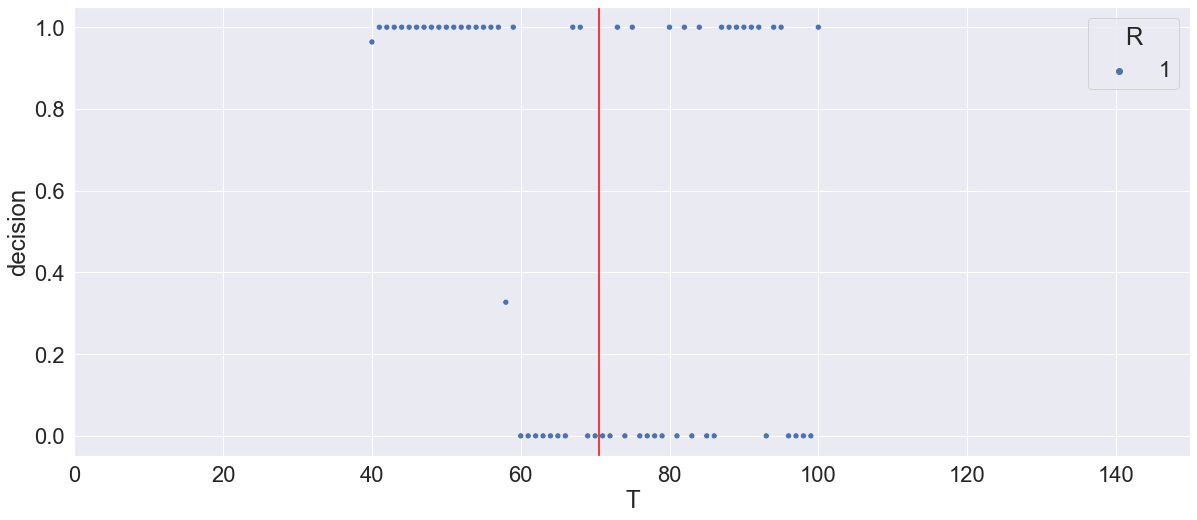

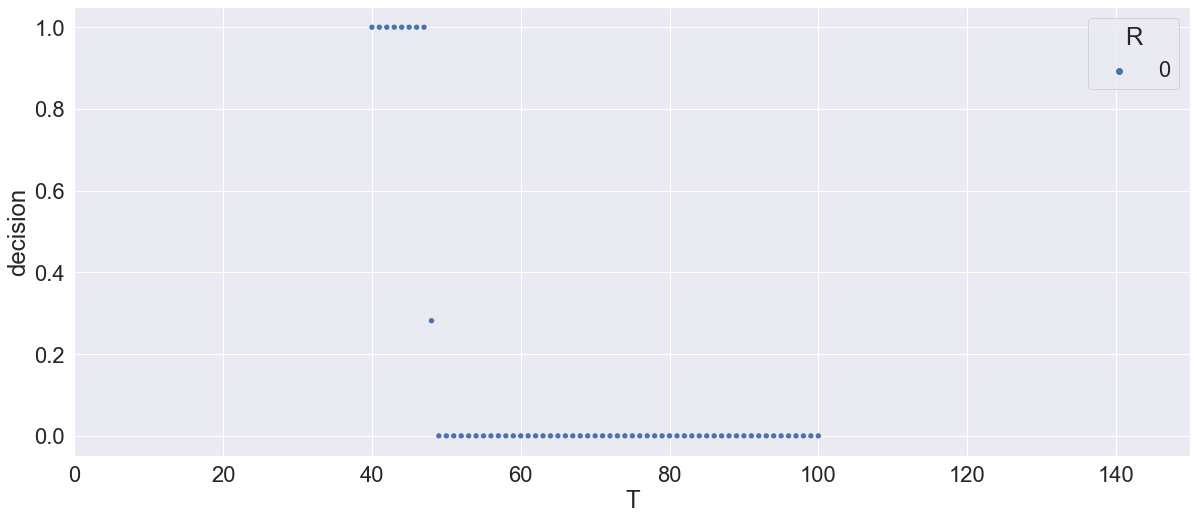

-----------


In [44]:


for upper_bound in [0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.9,1.0]:
    lower_bound = upper_bound- 0.05
    
    df_decisions = None
    max_utility = -1.0
    C_y_max = -0.1

    for C_y1 in np.linspace(lower_bound,upper_bound,101):
        
        C_y = C_y1
        dff['alpha_j'] = dff['Pr(X=X_j)']* (dff['ml_outcomes_prob'] - C_y)
        solver = pywraplp.Solver.CreateSolver('GLOP')
    
        
        applicant_stratum = []
        vars_cache = {}
        alpha_j = {}
        
        # Objective: Maximize the expected utility of the admitted students
        objective = solver.Objective()
        
        # For each stratum
        for ix, row in dff.iterrows():
            # probability of admission
            numvar = solver.NumVar(0.0, 1.0, str(ix))
            
            # store variable by index, and also by stratum R, T
            applicant_stratum.append(numvar)
            vars_cache[(row['R'],row['T'])] = numvar
            
            alpha_j[(row['R'],row['T'])] = row['alpha_j']
            
            # Benefit of admitting people is total utility in that stratum
            objective.SetCoefficient(applicant_stratum[ix], float(row['ml_outcomes']))
            
        objective.SetMaximization()
    
        # Constraint: At most K applicants
        K = int(len(df)*FRAC_ADMIT)
        admit_quota = solver.Constraint(0, K)
        
        # Total admits cannot exceed K 
        for ix, row in dff.iterrows():
            admit_quota.SetCoefficient(applicant_stratum[ix], float(row['N']))
        
        
        sum_alpha = 0
        R = 1 
        
        for T in list(dff[dff['R']==R]['T']):
            sum_alpha+= alpha_j[(R,T)] 
            
        cf_black = solver.Constraint(sum_alpha, sum_alpha)
        
        for T in list(dff[dff['R']==R]['T']):    
            cf_black.SetCoefficient(vars_cache[(R,T)], alpha_j[(R,T)] )    
        
        sum_alpha = 0
        R = 0
        
        for T in list(dff[dff['R']==R]['T']):
            sum_alpha+= alpha_j[(R,T)] 
            
        cf_white = solver.Constraint(sum_alpha, sum_alpha)
        
        for T in list(dff[dff['R']==R]['T']):    
            cf_white.SetCoefficient(vars_cache[(R,T)], alpha_j[(R,T)] )
            
        status = solver.Solve()
    
        if status != 2:
            TOTAL_UTILITY = 0
            for ix, row in dff.iterrows():
                TOTAL_UTILITY += float(row['ml_outcomes'])* vars_cache[(row['R'],row['T'])].solution_value()
            print(C_y,TOTAL_UTILITY)
            
            if TOTAL_UTILITY > max_utility:
                row = []
                admit = []
            
                for i in applicant_stratum:
                    row.append(int(str(i)))
                    admit.append(i.solution_value())
                
                df_decisions = pd.DataFrame({'row_id':row,'decision':admit})
                
                max_utility = TOTAL_UTILITY
                C_y_max = C_y
                
    if max_utility != -1.0:
            
        dff.merge(df_decisions,left_index=True,right_index=True).sort_values(by='ml_outcomes',ascending=False)
        xxx_ = dff.merge(df_decisions,left_index=True,right_index=True).sort_values(by='ml_outcomes',ascending=False)
        xxx_.sort_values(by='T')
        xxx = dff.merge(df_decisions,left_index=True,right_index=True).sort_values(by='ml_outcomes',ascending=False)
        xxx
        
        df['key'] = df['R'].astype(str)+'_'+df['T'].astype(str)
        xxx['key'] = xxx['R'].astype(str)+'_'+xxx['T'].astype(str)
        
        admit_decisions = df.merge(xxx,how='left',on='key')
        admit_decisions['decision_random'] = pd.Series([random.random() for x in range(0,len(admit_decisions))]) < FRAC_ADMIT['A']
        
        
        FRAC_BLACK_POLICY = (admit_decisions['R_y'] * admit_decisions['decision']).sum()/admit_decisions['decision'].sum()
        SUM_BP_POLICY = ( admit_decisions['B_p'] * admit_decisions['decision']).sum()
        
        FRAC_RANDOM_POLICY = (admit_decisions['R_y'] * admit_decisions['decision_random']).sum()/admit_decisions['decision_random'].sum()
        SUM_BP_RAND_POLICY = ( admit_decisions['B_p'] * admit_decisions['decision_random']).sum()
        
        file = open('./lp_results.csv','a')
        file.write('{}\t{}\t{}\t{}\t{}\n'.format('Counterfactual Pred. Parity',str(FRAC_BLACK_POLICY),str(SUM_BP_POLICY),str(C_y_max),str(max_utility)))
        file.close()
        
        
        sns.set(rc={'figure.figsize':(20,8.27)})
        sns.set(font_scale=2)  # crazy big
        g = sns.scatterplot(x='T',y='decision',hue='R',data=xxx[xxx['R']==1])
        g.set(xlim=(0, 150))
        plt.axvline(70.5, 0,1,color='red')
        
        plt.show()
        
        sns.set(rc={'figure.figsize':(20,8.27)})
        sns.set(font_scale=2)  # crazy big
        g = sns.scatterplot(x='T',y='decision',hue='R',data=xxx[xxx['R']==0])
        g.set(xlim=(0, 150))
        
        plt.show()
        
        print('-----------')
        
    

## Add CF Predictive Parity Constraints

,level_0,index,R,T,ml_outcomes,N,ml_outcomes_prob,Pr(X=X_j),alpha_j,row_id,decision
48,0,48,0,58,11249.799847,19969,0.556362,0.019969,-0.008859,48,0.000000
47,1,47,0,57,11088.165678,20387,0.542503,0.020387,-0.009327,47,0.000000
49,2,49,0,59,11050.515891,18966,0.583834,0.018966,-0.007893,49,0.000000
46,3,46,0,56,10948.852385,20884,0.515706,0.020884,-0.010114,46,0.000000
50,4,50,0,60,10938.026561,18179,0.605204,0.018179,-0.007177,50,0.997427
45,5,45,0,55,10848.984999,21501,0.499605,0.021501,-0.010759,45,0.000000
51,6,51,0,61,10818.850887,17438,0.617273,0.017438,-0.006674,51,1.000000
44,7,44,0,54,10545.586957,21749,0.481631,0.021749,-0.011274,44,0.000000
52,8,52,0,62,10532.523290,16488,0.639981,0.016488,-0.005936,52,1.000000
53,9,53,0,63,10275.368059,15645,0.653947,0.015645,-0.005414,53,1.000000


,level_0,index,R,T,ml_outcomes,N,ml_outcomes_prob,Pr(X=X_j),alpha_j,row_id,decision
119,218,119,1,6,0.266881,1,0.000000,0.000001,-0.000001,119,1.000000
120,217,120,1,7,0.268240,1,0.000000,0.000001,-0.000001,120,1.000000
121,214,121,1,8,0.539413,2,0.000000,0.000002,-0.000002,121,1.000000
122,212,122,1,9,0.813866,3,0.000000,0.000003,-0.000003,122,1.000000
0,220,0,0,10,0.085480,3,0.000000,0.000003,-0.000003,0,0.000000
123,199,123,1,10,1.364974,5,0.000000,0.000005,-0.000005,123,1.000000
124,211,124,1,11,0.824502,3,0.000000,0.000003,-0.000003,124,1.000000
1,221,1,0,11,0.030758,1,0.000000,0.000001,-0.000001,1,0.000000
2,219,2,0,12,0.232383,7,0.000000,0.000007,-0.000007,2,0.000000
125,188,125,1,12,3.598614,13,0.000000,0.000013,-0.000013,125,1.000000


,level_0,index,R,T,ml_outcomes,N,ml_outcomes_prob,Pr(X=X_j),alpha_j,row_id,decision
48,0,48,0,58,11249.799847,19969,0.556362,0.019969,-0.008859,48,0.000000
47,1,47,0,57,11088.165678,20387,0.542503,0.020387,-0.009327,47,0.000000
49,2,49,0,59,11050.515891,18966,0.583834,0.018966,-0.007893,49,0.000000
46,3,46,0,56,10948.852385,20884,0.515706,0.020884,-0.010114,46,0.000000
50,4,50,0,60,10938.026561,18179,0.605204,0.018179,-0.007177,50,0.997427
45,5,45,0,55,10848.984999,21501,0.499605,0.021501,-0.010759,45,0.000000
51,6,51,0,61,10818.850887,17438,0.617273,0.017438,-0.006674,51,1.000000
44,7,44,0,54,10545.586957,21749,0.481631,0.021749,-0.011274,44,0.000000
52,8,52,0,62,10532.523290,16488,0.639981,0.016488,-0.005936,52,1.000000
53,9,53,0,63,10275.368059,15645,0.653947,0.015645,-0.005414,53,1.000000


In [72]:
len(xxx_)

222

In [73]:
xxx.to_csv('./decision.csv')

In [74]:
solution = pd.read_csv('./decision.csv')

In [75]:
xxx

,level_0,index,R,T,ml_outcomes,N,ml_outcomes_prob,Pr(X=X_j),alpha_j,row_id,decision
48,0,48,0,58,11249.799847,19969,0.556362,0.019969,-0.008859,48,0.000000
47,1,47,0,57,11088.165678,20387,0.542503,0.020387,-0.009327,47,0.000000
49,2,49,0,59,11050.515891,18966,0.583834,0.018966,-0.007893,49,0.000000
46,3,46,0,56,10948.852385,20884,0.515706,0.020884,-0.010114,46,0.000000
50,4,50,0,60,10938.026561,18179,0.605204,0.018179,-0.007177,50,0.997427
45,5,45,0,55,10848.984999,21501,0.499605,0.021501,-0.010759,45,0.000000
51,6,51,0,61,10818.850887,17438,0.617273,0.017438,-0.006674,51,1.000000
44,7,44,0,54,10545.586957,21749,0.481631,0.021749,-0.011274,44,0.000000
52,8,52,0,62,10532.523290,16488,0.639981,0.016488,-0.005936,52,1.000000
53,9,53,0,63,10275.368059,15645,0.653947,0.015645,-0.005414,53,1.000000


In [76]:
(xxx['ml_outcomes']*xxx['decision']).sum()

312121.6725542521

In [80]:
len(xxx)

222

In [82]:
str(FRAC_BLACK_POLICY),str(SUM_BP_POLICY)

('0.5329654914191752', '246465.98459999997')

In [84]:
(xxx['N']*xxx['decision']).sum()/len(df)

0.48504600000000014

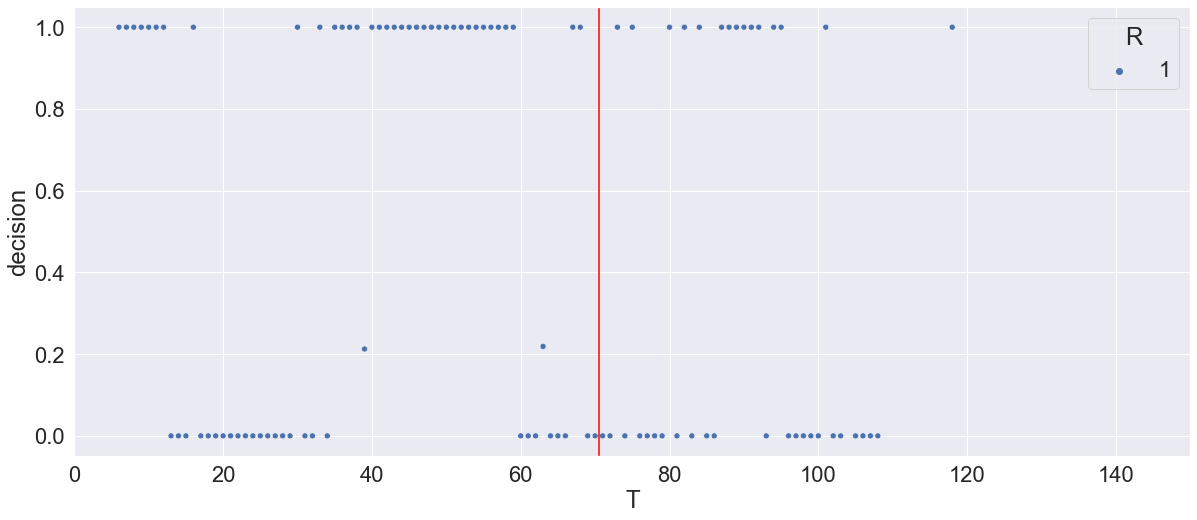

In [85]:
sns.set(rc={'figure.figsize':(20,8.27)})
sns.set(font_scale=2)  # crazy big
g = sns.scatterplot(x='T',y='decision',hue='R',data=xxx[xxx['R']==1])
g.set(xlim=(0, 150))
plt.axvline(70.5, 0,1,color='red')


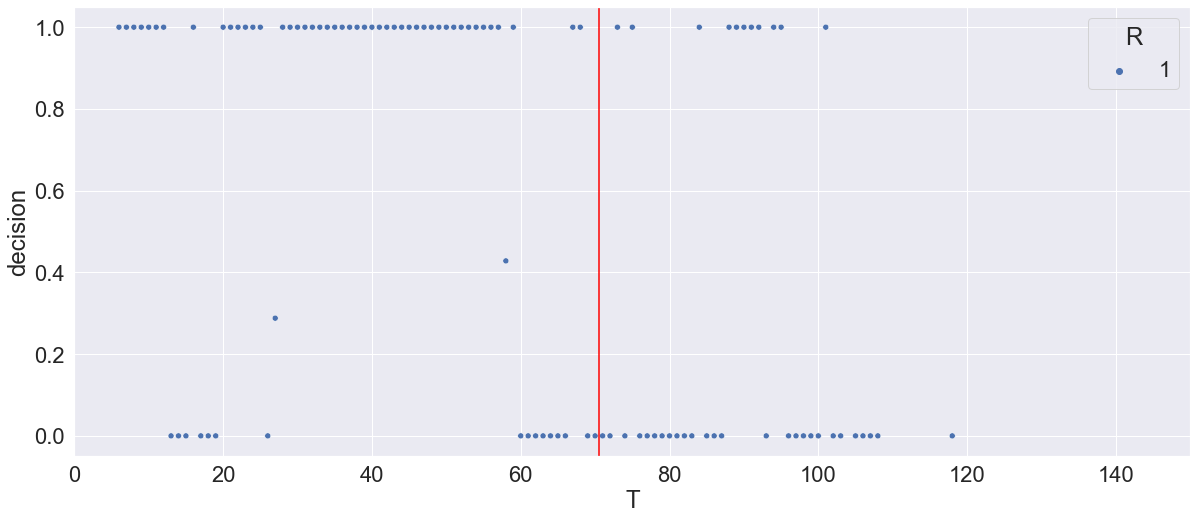

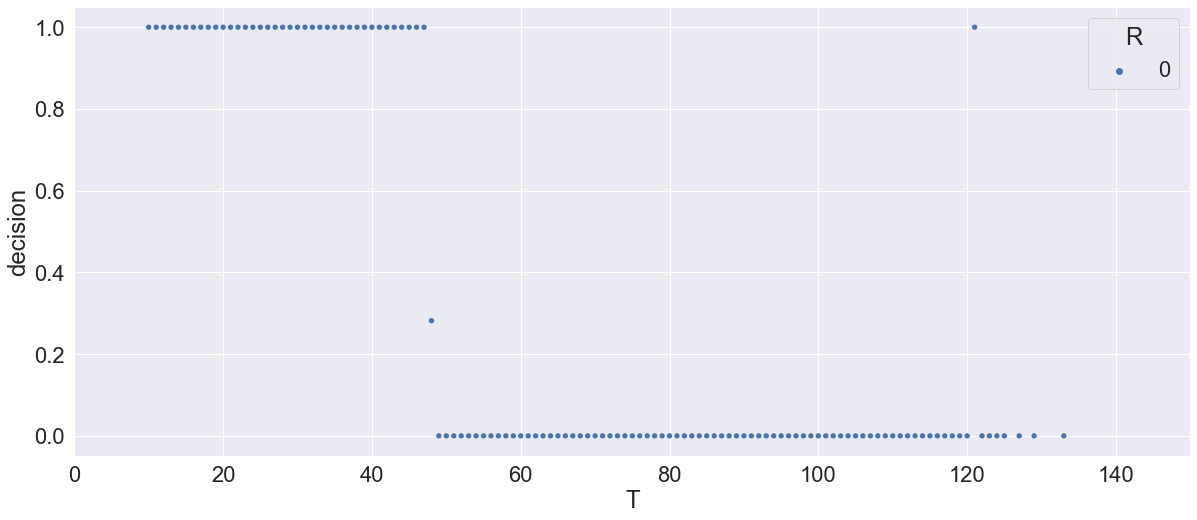

In [26]:
sns.set(rc={'figure.figsize':(20,8.27)})
sns.set(font_scale=2)  # crazy big
g = sns.scatterplot(x='T',y='decision',hue='R',data=xxx[xxx['R']==1])
g.set(xlim=(0, 150))
plt.axvline(70.5, 0,1,color='red')

plt.show()

sns.set(rc={'figure.figsize':(20,8.27)})
sns.set(font_scale=2)  # crazy big
g = sns.scatterplot(x='T',y='decision',hue='R',data=xxx[xxx['R']==0])
g.set(xlim=(0, 150))

plt.show()


In [87]:
admit_decisions[admit_decisions['decision']==0][['R_x','B_p']].groupby(['R_x']).mean()

,B_p
R_x,
0,0.380076
1,0.395198


In [88]:
str(FRAC_BLACK_POLICY),str(SUM_BP_POLICY)

('0.5329654914191752', '246465.98459999997')

In [89]:
SUM_BP_POLICY/(FRAC_ADMIT*len(df))

A    0.508129
dtype: float64

In [90]:
str(FRAC_BLACK_POLICY),str(SUM_BP_POLICY)

('0.5329654914191752', '246465.98459999997')

In [91]:
admit_decisions[admit_decisions['decision']==1]['B_p'].mean()

0.5056847578642384

In [92]:
(admit_decisions['decision'] * admit_decisions['ml_outcomes_x']).sum()

312121.672554252

In [93]:
(admit_decisions['decision'] * admit_decisions['B_p']).sum()

246465.98459999997

In [94]:
admit_decisions[admit_decisions['decision']==1]['B_p'].sum()

234573

In [95]:
(admit_decisions['decision'] * admit_decisions['B_p']).sum()/(len(admit_decisions)*FRAC_ADMIT)

A    0.508129
dtype: float64

In [96]:
(admit_decisions['decision'].sum())

485045.99999999994

In [97]:
admit_decisions['rand'] = pd.Series([random.random() for x in range(0,len(admit_decisions))])
admit_decisions['dec_binary'] = admit_decisions['rand'] < admit_decisions['decision']
admit_decisions[admit_decisions['dec_binary']==0][['R_x','B_p']].groupby(['R_x']).mean()

,B_p
R_x,
0,0.380116
1,0.380413
